In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds

In [2]:
# EVOLVE-BLOCK-START


def construct_packing():
    """
    Constructs an arrangement of 26 circles by combining a meta-heuristic
    search with a powerful SLSQP optimizer for refinement.
    """
    n = 26

    # --- Helper functions for the optimizer ---
    def objective_func(x):
        """The function to be minimized: the negative sum of radii."""
        return -np.sum(x[:n])

    def constraints_func(x):
        """
        Computes constraint violations. For SLSQP, each value must be >= 0.
        """
        radii = x[:n]
        centers = x[n:].reshape((n, 2))

        containment = np.concatenate(
            [
                centers[:, 0] - radii,
                centers[:, 1] - radii,
                1 - centers[:, 0] - radii,
                1 - centers[:, 1] - radii,
            ]
        )

        overlap = []
        for i in range(n):
            for j in range(i + 1, n):
                dist = np.linalg.norm(centers[i] - centers[j])
                overlap.append(dist - (radii[i] + radii[j]))

        return np.concatenate([containment, np.array(overlap)])

    def _compute_initial_radii(centers):
        """
        Computes a valid set of initial radii for a given set of centers
        to create a feasible starting point (x0) for the optimizer.
        """
        radii = np.min(
            [centers[:, 0], centers[:, 1], 1 - centers[:, 0], 1 - centers[:, 1]], axis=0
        )

        for _ in range(100):
            improved = False
            for i in range(n):
                for j in range(i + 1, n):
                    dist = np.linalg.norm(centers[i] - centers[j])
                    if radii[i] + radii[j] > dist:
                        excess = (radii[i] + radii[j] - dist) * 0.501
                        total_r = radii[i] + radii[j]
                        if total_r > 1e-9:
                            radii[i] -= excess * (radii[i] / total_r)
                            radii[j] -= excess * (radii[j] / total_r)
                            improved = True
            if not improved:
                break
        return np.maximum(radii, 1e-6)

    # --- 1. Generate a single high-quality initial guess ---
    centers_init = np.zeros((n, 2))
    inset = 0.06
    centers_init[0:4] = [
        [inset, inset],
        [1 - inset, inset],
        [inset, 1 - inset],
        [1 - inset, 1 - inset],
    ]
    centers_init[4:8] = [[0.5, inset], [0.5, 1 - inset], [inset, 0.5], [1 - inset, 0.5]]
    centers_init[8] = [0.5, 0.5]

    golden_angle = np.pi * (3 - np.sqrt(5))
    cx, cy = 0.5, 0.5
    inner_r, outer_r = 0.23, 0.48
    inner_idx, outer_idx = np.arange(9, 15), np.arange(15, 26)

    for i, idx in enumerate(inner_idx):
        angle = i * golden_angle
        centers_init[idx] = [cx + inner_r * np.cos(angle), cy + inner_r * np.sin(angle)]
    for i, idx in enumerate(outer_idx):
        angle = i * golden_angle * 1.003
        centers_init[idx] = [cx + outer_r * np.cos(angle), cy + outer_r * np.sin(angle)]

    centers_init += np.random.uniform(
        -0.01, 0.01, size=(n, 2)
    )  # Increased initial jitter
    centers_init = np.clip(centers_init, 0.01, 0.99)

    # --- 2. Define bounds and constraints for the solver ---
    bounds = Bounds([0.0] * n + [0.0] * (2 * n), [0.5] * n + [1.0] * (2 * n))
    constraints = {"type": "ineq", "fun": constraints_func}

    # --- 3. Initial baseline optimization ---
    radii_init = _compute_initial_radii(centers_init)
    x0 = np.concatenate([radii_init, centers_init.flatten()])

    result = minimize(
        objective_func,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 600, "ftol": 1e-8, "disp": False},
    )  # Increased initial maxiter

    # Initialize current and best solutions for SA
    best_x = result.x.copy()
    current_x = result.x.copy()
    best_score = -result.fun
    current_score = -result.fun

    # --- 4. Simulated Annealing loop: Perturb and refine with acceptance criterion ---
    sa_iterations = 250  # Significantly increased iterations for SA
    temperature = 0.05  # Initial temperature for SA
    initial_temperature = temperature  # Preserve for potential reheating
    cooling_rate = 0.995  # Slower cooling rate for broader search
    perturb_step = 0.04  # Initial step size for perturbations
    initial_perturb_step = perturb_step  # Preserve for potential reheating
    step_decay = 0.999  # Decay rate for step size
    last_improve = 0  # Iteration of last best improvement
    stagnation_limit = sa_iterations // 4  # Iterations before triggering reheating

    for iter_idx in range(sa_iterations):
        candidate_centers = (
            current_x[n:].reshape((n, 2)).copy()
        )  # Start from current state

        # Select a move type: 70% local, 30% global ring rotation
        if np.random.rand() < 0.7:
            # Local move: perturb a few circles
            num_to_move = np.random.randint(2, 6)
            indices = np.random.choice(n, num_to_move, replace=False)
            candidate_centers[indices] += np.random.normal(
                0, perturb_step, size=(num_to_move, 2)
            )
        else:
            # Global move: rotate one of the rings
            idx_to_rotate = inner_idx if np.random.rand() < 0.5 else outer_idx
            center_point = candidate_centers[8]  # Center of the overall pattern
            angle = np.random.normal(
                0, 0.15
            )  # Angular perturbation (can be fixed or scaled)
            rel_pos = candidate_centers[idx_to_rotate] - center_point
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            rotated = np.column_stack(
                [
                    cos_a * rel_pos[:, 0] - sin_a * rel_pos[:, 1],
                    sin_a * rel_pos[:, 0] + cos_a * rel_pos[:, 1],
                ]
            )
            candidate_centers[idx_to_rotate] = center_point + rotated

        candidate_centers = np.clip(
            candidate_centers, 0.01, 0.99
        )  # Clip to stay within bounds

        # Create a new starting point and run a shorter refinement optimization
        x0_candidate = np.concatenate(
            [_compute_initial_radii(candidate_centers), candidate_centers.flatten()]
        )
        refine_result = minimize(
            objective_func,
            x0_candidate,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
            options={"maxiter": 150, "ftol": 1e-6, "disp": False},
        )  # Reduced maxiter, looser ftol

        new_score = -refine_result.fun

        # Simulated Annealing Acceptance Criterion
        # Accept if better, or with probability if worse (based on temperature)
        if new_score > current_score or (
            temperature > 1e-7
            and np.random.rand() < np.exp((new_score - current_score) / temperature)
        ):
            current_score = new_score
            current_x = refine_result.x.copy()  # Update current state
            if new_score > best_score:
                best_score = new_score
                best_x = refine_result.x.copy()  # Update global best
                last_improve = iter_idx  # Reset stagnation counter on improvement
        # If not accepted, current_x remains unchanged for the next iteration (implicit)

        # Cool down temperature and decay perturbation step size
        temperature *= cooling_rate
        perturb_step *= step_decay
        if temperature < 1e-7:
            temperature = 1e-7  # Prevent division by zero
        if perturb_step < 1e-5:
            perturb_step = 1e-5  # Prevent step from becoming too small
        # Reheat if stagnated beyond stagnation_limit
        if iter_idx - last_improve > stagnation_limit:
            temperature = initial_temperature
            perturb_step = initial_perturb_step
            last_improve = iter_idx

    # --- 5. Final Polishing Run on the best found solution ---
    final_result = minimize(
        objective_func,
        best_x,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 1000, "ftol": 1e-9, "disp": False},
    )  # Increased maxiter for final polish

    # Check if the final polishing improved the best_x from SA
    if -final_result.fun > best_score:
        best_x = final_result.x.copy()  # Make sure to copy

    # --- 6. Unpack and return the best result ---
    final_radii = best_x[:n]
    final_centers = best_x[n:].reshape((n, 2))
    return final_centers, final_radii


# EVOLVE-BLOCK-END


# This part remains fixed (not evolved)
def run_packing():
    """Run the circle packing constructor for n=26"""
    centers, radii = construct_packing()
    # Calculate the sum of radii
    sum_radii = np.sum(radii)
    return centers, radii, sum_radii


np.random.seed(7)
centers, radii, sum_radii = run_packing()
print(sum_radii)

2.635983099011548


In [3]:
from typing import Tuple, Optional


def adapted_validate_packing(
    run_output: Tuple[np.ndarray, np.ndarray, float], atol: float = 1e-7
) -> Tuple[bool, Optional[str]]:
    """
    Validates circle packing results based on the output of 'run_packing'.

    Args:
        run_output: Tuple (centers, radii, reported_sum) from run_packing.

    Returns:
        (is_valid: bool, error_message: Optional[str])
    """
    centers, radii, reported_sum = run_output

    if not isinstance(centers, np.ndarray):
        centers = np.array(centers)
    if not isinstance(radii, np.ndarray):
        radii = np.array(radii)

    n_expected = 26
    if centers.shape != (n_expected, 2):
        msg = (
            f"Centers shape incorrect. Expected ({n_expected}, 2), got {centers.shape}"
        )
        return False, msg
    if radii.shape != (n_expected,):
        msg = f"Radii shape incorrect. Expected ({n_expected},), got {radii.shape}"
        return False, msg

    if np.any(radii < 0):
        negative_indices = np.where(radii < 0)[0]
        msg = f"Negative radii found for circles at indices: {negative_indices}"
        return False, msg

    if not np.isclose(np.sum(radii), reported_sum, atol=atol):
        msg = (
            f"Sum of radii ({np.sum(radii):.6f}) does not match "
            f"reported ({reported_sum:.6f})"
        )
        return False, msg

    for i in range(n_expected):
        x, y = centers[i]
        r = radii[i]
        is_outside = (
            x - r < -atol or x + r > 1 + atol or y - r < -atol or y + r > 1 + atol
        )
        if is_outside:
            msg = (
                f"Circle {i} (x={x:.4f}, y={y:.4f}, r={r:.4f}) is outside unit square."
            )
            return False, msg

    for i in range(n_expected):
        for j in range(i + 1, n_expected):
            dist = np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
            if dist < radii[i] + radii[j] - atol:
                msg = (
                    f"Circles {i} & {j} overlap. Dist: {dist:.4f}, "
                    f"Sum Radii: {(radii[i] + radii[j]):.4f}"
                )
                return False, msg
    return True, None


for atol in [1e-6, 1e-7, 0]:
    print(atol, adapted_validate_packing((centers, radii, sum_radii), atol=atol))


1e-06 (True, None)
1e-07 (True, None)
0 (False, 'Circle 0 (x=0.0849, y=0.0849, r=0.0849) is outside unit square.')


In [4]:
radii_adapted = radii - 1e-8
print(np.sum(radii_adapted))
for atol in [1e-6, 1e-7, 0]:
    print(
        atol, adapted_validate_packing((centers, radii_adapted, sum_radii), atol=atol)
    )


2.6359828390115476
1e-06 (True, None)
1e-07 (True, None)
0 (True, None)


In [5]:
import itertools

# AlphaEvolve Validation


def verify_circles(circles: np.ndarray):
    """Checks that the circles are disjoint and lie inside a unit square.

    Args:
      circles: A numpy array of shape (num_circles, 3), where each row is
        of the form (x, y, radius), specifying a circle.

    Raises:
      AssertionError if the circles are not disjoint or do not lie inside the
      unit square.
    """
    # Check pairwise disjointness.
    for circle1, circle2 in itertools.combinations(circles, 2):
        center_distance = np.sqrt(
            (circle1[0] - circle2[0]) ** 2 + (circle1[1] - circle2[1]) ** 2
        )
        radii_sum = circle1[2] + circle2[2]
        assert center_distance >= radii_sum, (
            f"Circles are NOT disjoint: {circle1} and {circle2}."
        )

    # Check all circles lie inside the unit square [0,1]x[0,1].
    for circle in circles:
        assert (
            0 <= min(circle[0], circle[1]) - circle[2]
            and max(circle[0], circle[1]) + circle[2] <= 1
        ), f"Circle {circle} is NOT fully inside the unit square."


verify_circles(np.column_stack((centers, radii_adapted)))

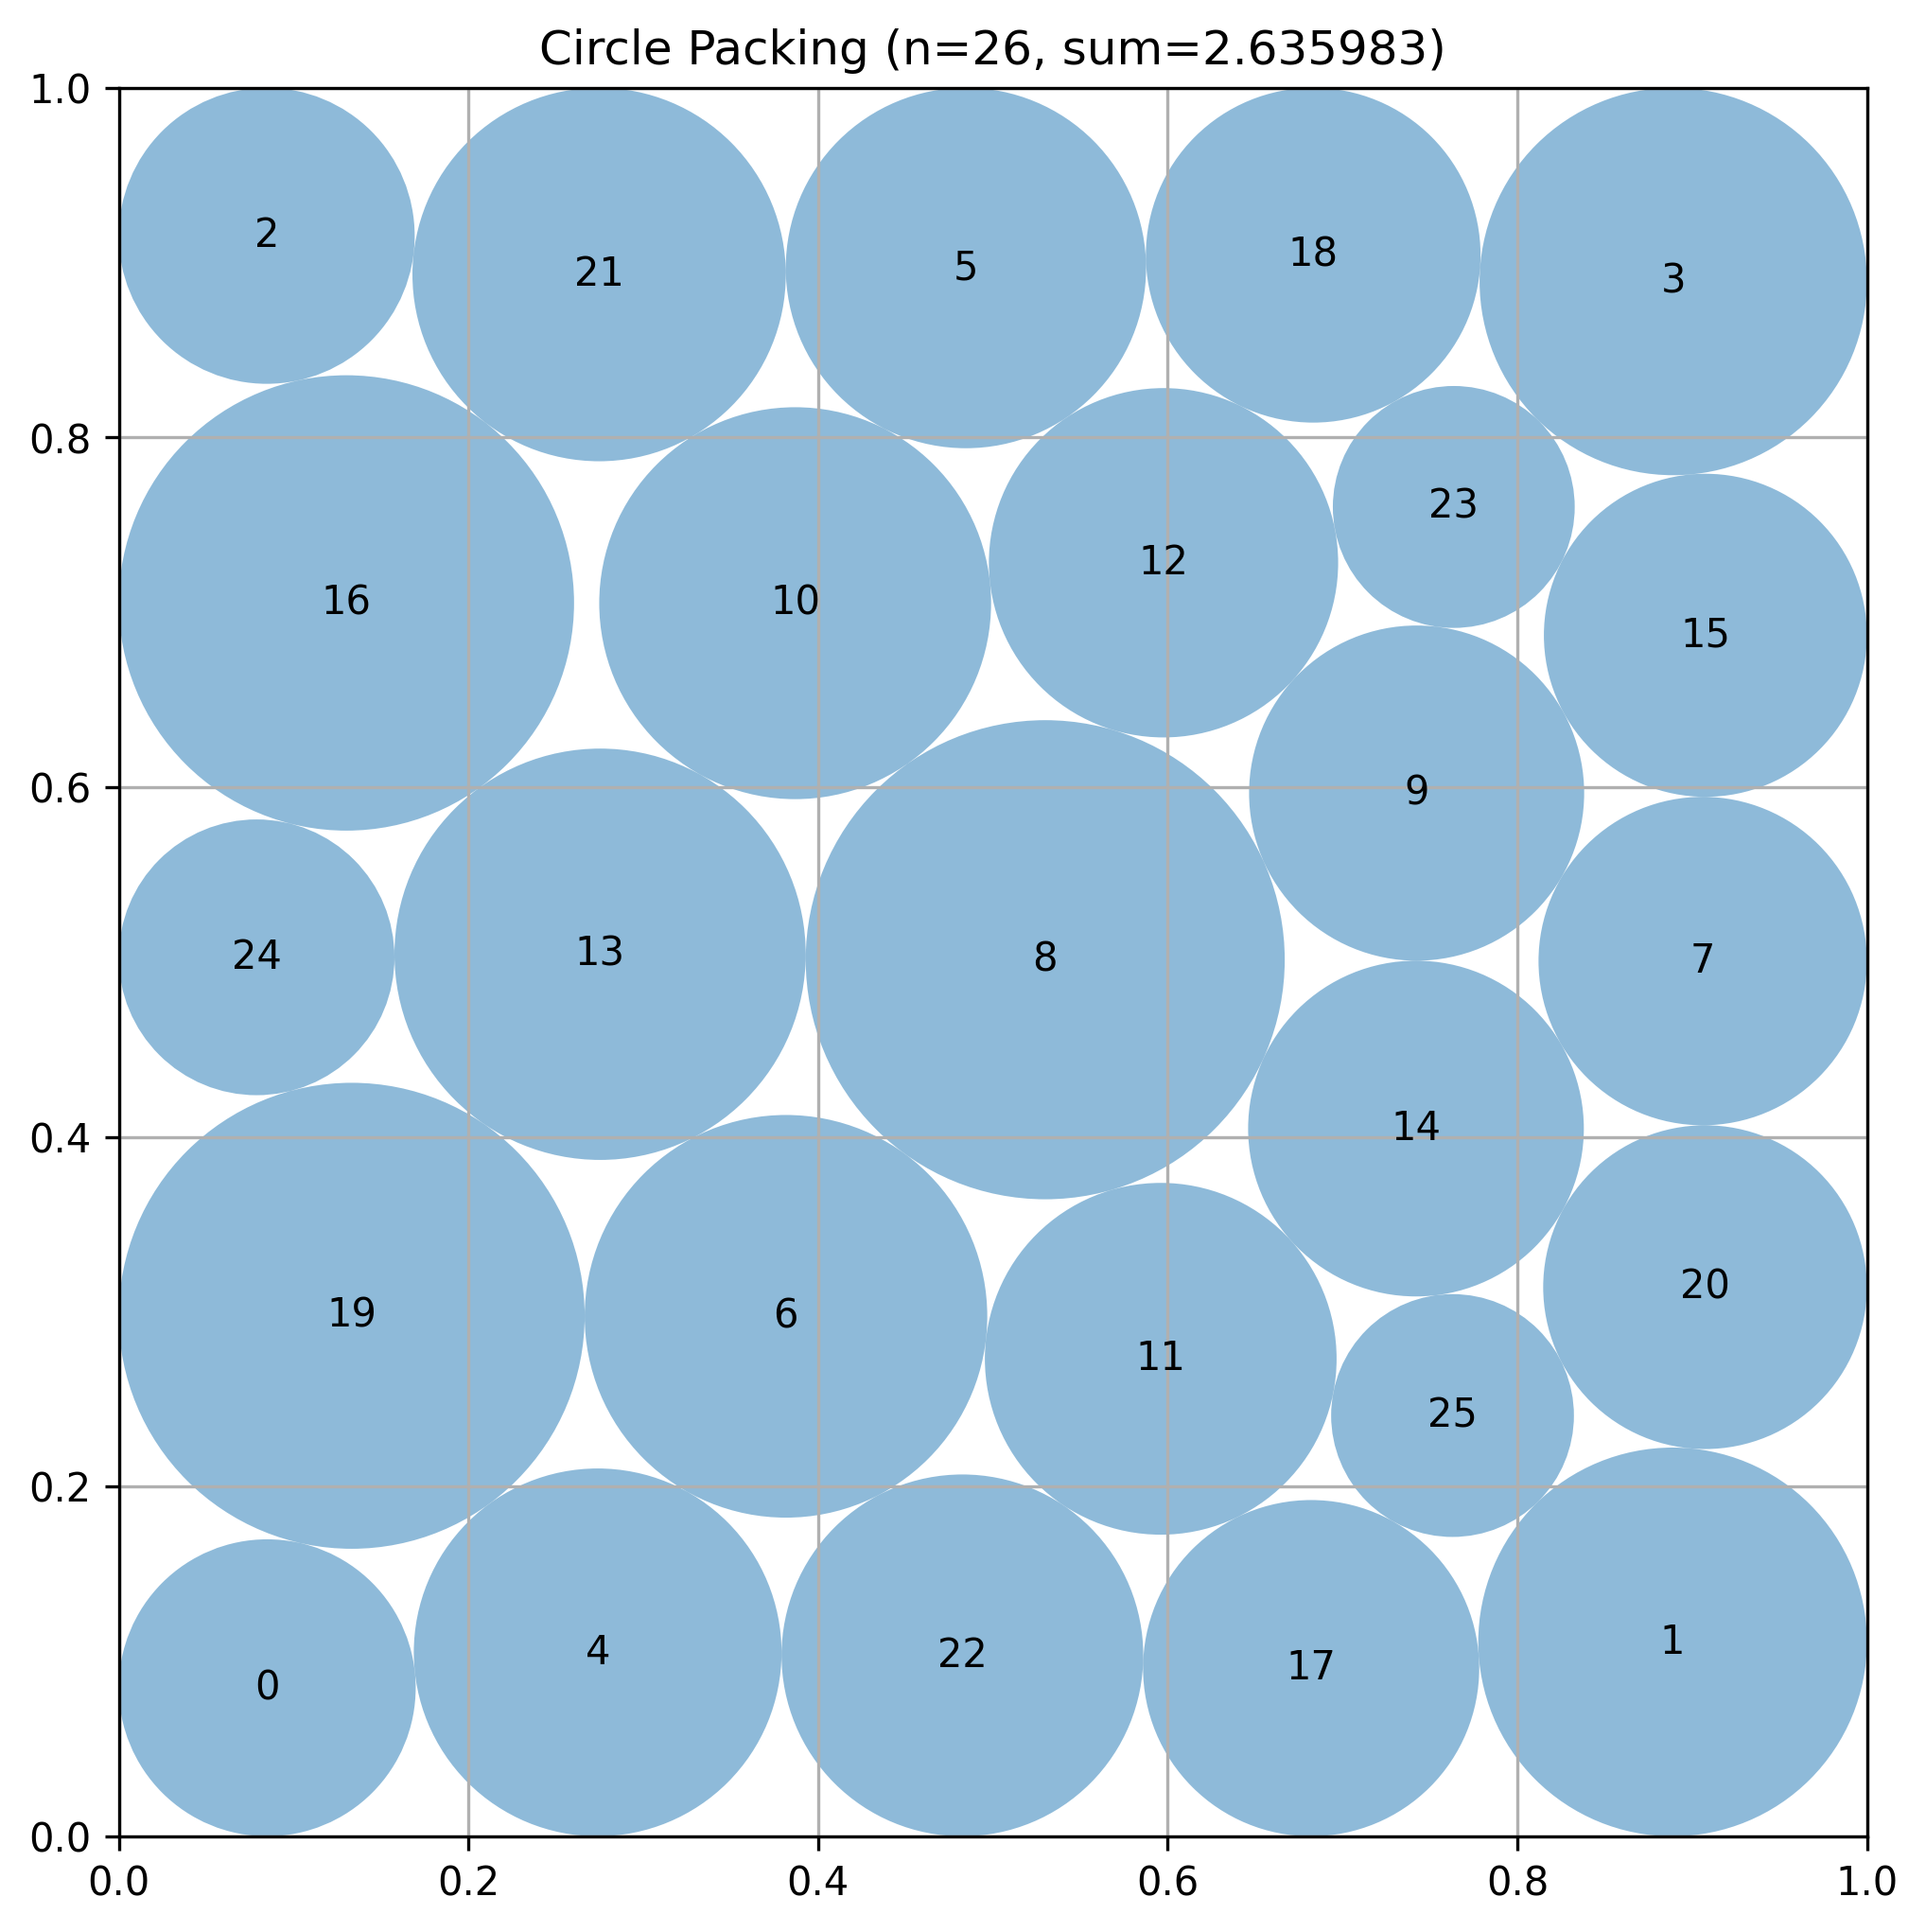

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# set high dpi for all figures
plt.rcParams["figure.dpi"] = 300


def visualize(centers, radii):
    """
    Visualize the circle packing

    Args:
        centers: np.array of shape (n, 2) with (x, y) coordinates
        radii: np.array of shape (n) with radius of each circle
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw unit square
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.grid(True)

    # Draw circles
    for i, (center, radius) in enumerate(zip(centers, radii)):
        circle = Circle(center, radius, alpha=0.5)
        ax.add_patch(circle)
        ax.text(center[0], center[1], str(i), ha="center", va="center")

    ax.set_title(f"Circle Packing (n={len(centers)}, sum={sum(radii):.6f})")
    return fig, ax


fig, ax = visualize(centers, radii_adapted)
# store as pdf
fig.savefig("circle_packing_results_adapted.pdf", bbox_inches="tight", dpi=300)